In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import tranVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
label_ratio = 0.7

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'


tranvae_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [6]:
adata_all = sc.read(os.path.expanduser(f'~/Documents/benchmarking_datasets/pancreas_normalized.h5ad'))
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
conditions = adata.obs[condition_key].unique().tolist()
labels = adata.obs[cell_type_key].unique().tolist()

In [7]:
idx = np.arange(len(adata))
np.random.shuffle(idx)
n_labeled = int(label_ratio*len(adata))
labeled_ind = idx[:n_labeled]

In [8]:
print(adata.obs[condition_key][labeled_ind].unique().tolist())
print(adata.obs[condition_key][~labeled_ind].unique().tolist())
print(adata.obs[cell_type_key][labeled_ind].unique().tolist())
print(adata.obs[cell_type_key][~labeled_ind].unique().tolist())

[]
[]
[]
[]


In [9]:
tranvae = scarches.models.tranVAE(
    input_dim=adata.n_vars,
    conditions=conditions,
    cell_types=labels,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [10]:
tranvae.condition_encoder

{'Pancreas inDrop': 0,
 'Pancreas CelSeq2': 1,
 'Pancreas CelSeq': 2,
 'Pancreas Fluidigm C1': 3,
 'Pancreas SS2': 4}

In [11]:
tranvae.cell_type_encoder

{'Pancreas Endothelial': 0,
 'Pancreas Acinar': 1,
 'Pancreas Beta': 2,
 'Pancreas Delta': 3,
 'Pancreas Stellate': 4,
 'Pancreas Ductal': 5,
 'Pancreas Alpha': 6,
 'Pancreas Gamma': 7}

In [12]:
sup_trainer = scarches.trainers.tranVAETrainer(
    model=tranvae,
    adata=adata,
    n_clusters=8,
    labeled_indices=labeled_ind,
    condition_key=condition_key,
    cell_type_key=cell_type_key,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=1000,
    tau=0,
)

In [13]:
sup_trainer.train(
    n_epochs=tranvae_epochs,
)

 |███████-------------| 36.4%  - epoch_loss: 2640.36 - epoch_trvae_loss: 2602.14 - epoch_classifier_loss:   38.22 - epoch_unlabeled_loss:    0.04 - epoch_labeled_loss:    0.00 - val_loss: 1884.98 - val_trvae_loss: 1810.64 - val_classifier_loss:   74.34 - val_unlabeled_loss:    0.07 - val_labeled_loss:    0.0000000
ADJUSTED LR
 |███████-------------| 37.8%  - epoch_loss: 2614.64 - epoch_trvae_loss: 2582.17 - epoch_classifier_loss:   32.47 - epoch_unlabeled_loss:    0.03 - epoch_labeled_loss:    0.00 - val_loss: 1877.30 - val_trvae_loss: 1795.78 - val_classifier_loss:   81.52 - val_unlabeled_loss:    0.08 - val_labeled_loss:    0.00
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 167


... storing 'celltype' as categorical
... storing 'batch' as categorical


[<AxesSubplot:title={'center':'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>]

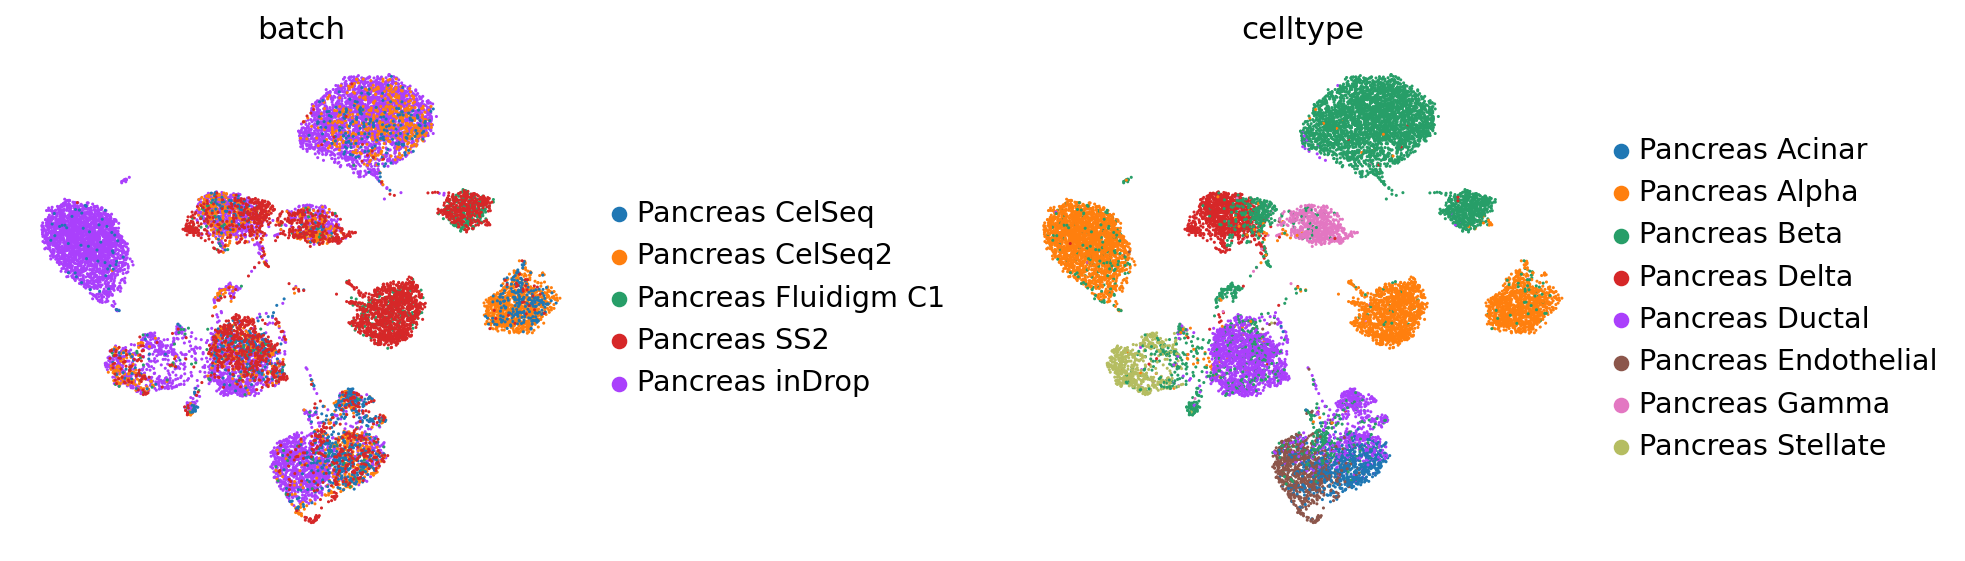

In [14]:
device = next(tranvae.parameters()).device
x = torch.tensor(adata.X, device=device)
c = np.asarray(adata.obs[condition_key])
labels = np.zeros(c.shape[0])
for condition, label in tranvae.condition_encoder.items():
    labels[c == condition] = label
c = torch.tensor(labels, device=device)

adata_latent = sc.AnnData(tranvae.get_latent(x, c).cpu().detach().numpy())
adata_latent.obs['celltype'] = adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()
adata_latent.obs['predictions'] = tranvae.classify(x, c).cpu().detach().numpy()

sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'celltype'],
           frameon=False,
           wspace=0.6,
           show=False
           )

In [15]:
celltypes = np.asarray(adata.obs[cell_type_key])
ct_labels = np.zeros(celltypes.shape[0])
for celltype, label in tranvae.cell_type_encoder.items():
    ct_labels[celltypes == celltype] = label
print("Acc: {}".format(np.mean(adata_latent.obs.predictions == ct_labels)))

In [16]:
landmarks_labeled = sup_trainer.landmarks_labeled.cpu().numpy()
landmarks_unlabeled = torch.stack(sup_trainer.landmarks_unlabeled).squeeze().cpu().numpy()
print(landmarks_labeled)
print(landmarks_unlabeled)

[[ 0.49 -1.65 -0.66 -0.64  0.22 -0.02 -0.04 -0.04  0.06 -0.07]
 [ 0.34  0.23  0.85 -0.43  0.33 -0.78 -0.24 -0.08  0.1   0.06]
 [ 0.44  2.23 -0.41 -0.3   0.25  0.15  0.01 -0.06 -0.49 -0.14]
 [ 0.4   0.38 -0.57 -2.46  0.26  0.01 -0.05 -0.23 -0.06  0.09]
 [ 0.37  0.06 -0.13  1.6   0.32  0.28 -0.07 -0.15 -0.25  0.04]
 [ 0.29  0.05 -1.02 -0.24  0.31 -0.18 -0.32 -0.1  -1.77 -0.09]
 [ 0.48  0.41 -1.29 -0.1   0.25  0.39 -0.07 -0.08  1.05 -0.01]
 [ 0.38  0.05  0.43 -0.76  0.33  1.51 -0.05 -0.   -0.73 -0.12]]


In [17]:
extended_latent = adata_latent.X.copy()
extended_latent = np.concatenate((extended_latent, landmarks_labeled), axis=0)
extended_latent = np.concatenate((extended_latent, landmarks_unlabeled), axis=0)

extended_latent_labels = adata_latent.obs['celltype'].tolist()
landmark_names=[]
for i in range(landmarks_labeled.shape[0]):
    landmark_names.append(f'Landmark{i}')
    
extended_latent_labels+=landmark_names   
extended_latent_labels+=landmark_names
    
extended_latent_batches = adata_latent.obs['batch'].tolist()
extended_latent_batches += landmarks_labeled.shape[0]*['Landmarks_labeled']
extended_latent_batches += landmarks_unlabeled.shape[0]*['Landmarks_unlabeled']

extended_latent = sc.AnnData(extended_latent)
extended_latent.obs['celltype'] = extended_latent_labels
extended_latent.obs['batch'] = extended_latent_batches
extended_latent

NameError: name 'landmarks_labeled' is not defined

In [ ]:
sc.pp.neighbors(extended_latent, n_neighbors=8)
sc.tl.leiden(extended_latent)
sc.tl.umap(extended_latent)

In [ ]:
sc.pl.umap(extended_latent,
           color=['celltype'],
           groups=landmark_names,
           frameon=False,
           wspace=0.6,
           show=False,
           size=50
           )

In [ ]:
#landmark_batches = ['Landmarks_labeled']
#landmark_batches = ['Landmarks_unlabeled']
landmark_batches = ['Landmarks_labeled', 'Landmarks_unlabeled']
sc.pl.umap(extended_latent,
           color=['batch'],
           frameon=False,
           groups=landmark_batches,
           wspace=0.6,
           show=False,
           size=50
           )

In [ ]:
celltypes = adata_latent.obs['celltype'].unique().tolist()
sc.pl.umap(extended_latent,
           color=['celltype'],
           frameon=False,
           groups=celltypes,
           wspace=0.6,
           show=False,
           size=50
           )